In [35]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
sales_data = pd.read_csv("./data/sales.csv")
sales_data.head()

print(sales_data.state_holiday.unique())

le = LabelEncoder()
sales_data.state_holiday = le.fit_transform(sales_data.state_holiday)

['0' 'a' 'c' 'b']


In [22]:
sales_data.head()

print(sales_data.dtypes)

Unnamed: 0              int64
store_ID                int64
day_of_week             int64
date                   object
nb_customers_on_day     int64
open                    int64
promotion               int64
state_holiday           int64
school_holiday          int64
sales                   int64
dtype: object


## Handle date column

In [26]:
sales_data.date = pd.to_datetime(sales_data.date)
sales_data["month"] = sales_data.date.dt.month
sales_data["year"] = sales_data.date.dt.year

sales_data.drop(columns=["date"], inplace=True)

print(sales_data.head())

   Unnamed: 0  store_ID  day_of_week  nb_customers_on_day  open  promotion  \
0      425390       366            4                  517     1          0   
1      291687       394            6                  694     1          0   
2      411278       807            4                  970     1          1   
3      664714       802            2                  473     1          1   
4      540835       726            4                 1068     1          1   

   state_holiday  school_holiday  sales  month  year  
0              0               0   4422      4  2013  
1              0               0   8297      4  2015  
2              0               0   9729      8  2013  
3              0               0   6513      5  2013  
4              0               0  10882     10  2013  


## Set missing index name

In [32]:
sales_data.rename(columns={sales_data.columns[0]: 'index'}, inplace=True)

## Check missing values

In [33]:
print(sales_data.isnull().sum())

index                  0
store_ID               0
day_of_week            0
nb_customers_on_day    0
open                   0
promotion              0
state_holiday          0
school_holiday         0
sales                  0
month                  0
year                   0
dtype: int64


## Check corrolation between features

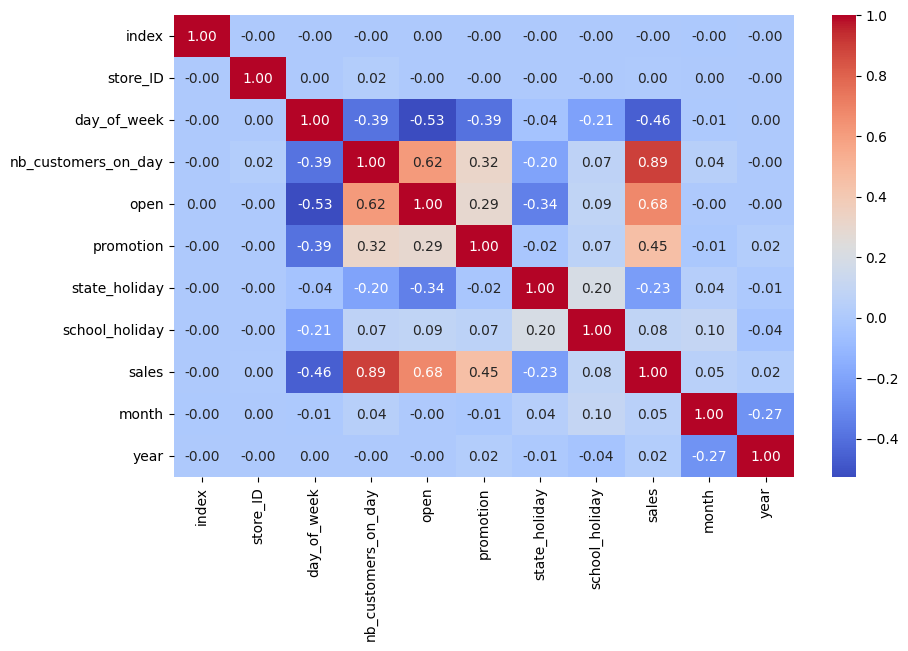

In [38]:
corrolation_matrix = sales_data.corr(numeric_only=True)

plt.figure(figsize=[10, 6])
sns.heatmap(corrolation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()